# Project Definition and Problem Framing

## 1. Define the Objective

The goal of this project is to **predict the price of a car based on its features**.
The price is a continuous target variable, and the prediction will be based on attributes such as brand, model, horsepower, fuel type, transmission, etc.

**Objective (concise):**
> Predict the selling price of a car using its technical and categorical features to provide a data-driven estimate of vehicle value.

---

## 2. How should you frame this problem?

- **Type of learning:**
  → **Supervised learning**
  Since we have labeled data with features and a target price.

- **Problem type:**
  → **Regression**
  Because the target variable (`price`) is continuous numerical data, not categories.

---

## 3. How should performance be measured?

Typical regression evaluation metrics include:

| Metric          | Explanation                                                            |
|-----------------|------------------------------------------------------------------------|
| **MSE**         | Mean Squared Error – penalizes large errors heavily                    |
| **RMSE**        | Root Mean Squared Error – easier to interpret as it’s in the unit of price |
| **MAE**         | Mean Absolute Error – average absolute difference                      |
| **R² Score**    | Proportion of variance explained by the model (max is 1.0)            |

**Recommended:** Use RMSE for error magnitude plus R² for overall fit.

Example in code:

        ```python
        from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
        import numpy as np

        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)


## 4. What would be the minimum performance needed?
This is optional but important in real projects.

**Example answer:**

In a real-world scenario, an RMSE below €3,000 might be acceptable for average car prices around €25,000. Additionally, the model should explain at least 80% of the price variance (R² > 0.8). These thresholds depend on the specific use case (e.g., private sales vs. dealer valuation).

You can skip this step or provide a rough estimate for learning purposes.


## 5. How would you solve the problem manually?
This helps to understand the intuition behind the problem.

Manually, I would look for comparable cars — similar brand, model, year, horsepower, colors, and features. Then I would estimate the price based on the prices of these similar vehicles. Important factors would be brand, horsepower, condition, mileage, transmission type, and fuel type.

**Summary:**

- Find similar cars by key features.
- Compare their price ranges.
- Estimate an average or weighted price.
- Adjust for special features like warranty or color.

This is similar to a manual k-nearest neighbors approach.


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
loaded_data = pd.read_csv('../data/topic21_v23_train.csv')

loaded_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7962 entries, 0 to 7961
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   0                   7501 non-null   float64
 1   1                   7472 non-null   float64
 2   2                   7359 non-null   float64
 3   3                   7556 non-null   float64
 4   4                   7495 non-null   float64
 5   brand               7962 non-null   object 
 6   model               7962 non-null   object 
 7   trim                7951 non-null   object 
 8   body_type           7962 non-null   object 
 9   fuel_type           7962 non-null   object 
 10  transmission_type   7962 non-null   object 
 11  engine_capacity_cc  6362 non-null   object 
 12  horsepower          7584 non-null   object 
 13  exterior_color      7962 non-null   object 
 14  interior_color      7962 non-null   object 
 15  warranty            7962 non-null   object 
 16  city  

In [21]:
print(loaded_data['price'].describe())
q75 = loaded_data['price'].quantile(0.75)
print("\n75 quantile = ", q75)
print("not in 75 quantile:", (loaded_data['price'] > q75).sum())

count      7962.000000
mean     163331.653228
std      188397.899880
min        1000.000000
25%       44999.250000
50%       93000.000000
75%      207000.000000
max      999900.000000
Name: price, dtype: float64

75 quantile =  207000.0
not in 75 quantile: 1990


In [22]:
def add_outlier_column(df, threshold=2.5):
    df_copy = df.copy()

    if 'price' not in df.columns:
        numeric_cols = df.select_dtypes(include=['float64', 'int64'])
    else:
        numeric_cols = df.select_dtypes(include=['float64', 'int64']).drop('price', axis=1).columns

    df_copy['is_outlier'] = 0
    for col in numeric_cols:
        z_scores = np.abs((df[col] - df[col].mean()) / df[col].std())
        df_copy['is_outlier'] = (df_copy['is_outlier'] | (z_scores > threshold)).astype(int)

    return df_copy

In [23]:

def parse_mid(r):
    if pd.isna(r) or r == 'Unknown': return np.nan
    s = ''.join(c for c in r if c.isdigit() or c == '-')
    if '-' in s:
        lo, hi = map(int, s.split('-'))
        return (lo + hi) / 2
    return float(s)

In [ ]:
def remove_outliers(df, columns, factor=2.5, only_upper=True):
    df_clean = df.copy()

    for col in columns:
        before_count = len(df_clean)

        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        upper_bound = Q3 + factor * IQR

        if only_upper:
            df_clean = df_clean[df_clean[col] <= upper_bound]
        else:
            lower_bound = Q1 - factor * IQR
            df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]

        after_count = len(df_clean)
        removed = before_count - after_count
        print(f"Removed {removed} raw from col: '{col}'")

    return df_clean

In [24]:
MEANS = {}

def feature_engineer(df, is_train):
    for col in ['engine_capacity_cc', 'horsepower']:
        df[col + '_num'] = df[col].apply(parse_mid)
        df[col + '_miss'] = df[col + '_num'].isna().astype(int)
        df.drop(columns=[col], inplace=True)

    df['is_automatic'] = (df['transmission_type'] == 'Automatic Transmission').astype(int)
    df = df.drop('transmission_type', axis=1)

    df['hp_per_cc'] = df['horsepower_num'] / df['engine_capacity_cc_num']

    df = add_outlier_column(df, 2)
    print("Number of outliers:", df['is_outlier'].sum())

    if is_train:
        for col in ['model']:
            MEANS[col] = df.groupby(col)['price'].mean()
            df[col + '_enc'] = df[col].map(MEANS[col])
    else:
        for col in ['model']:
            df[col + '_enc'] = df[col].map(MEANS[col])

    df.drop(columns=['model'], inplace=True)
    return df

In [25]:
from sklearn.model_selection import train_test_split

df = loaded_data.copy()

train_set, valid_set = train_test_split(df, test_size=0.2, random_state=42)

train_set = feature_engineer(train_set, True)
valid_set = feature_engineer(valid_set, False)


Number of outliers: 2024
Number of outliers: 516


### Data Visualization

In [26]:
data = train_set.copy()

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6369 entries, 2864 to 7270
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   0                        5995 non-null   float64
 1   1                        5997 non-null   float64
 2   2                        5876 non-null   float64
 3   3                        6038 non-null   float64
 4   4                        5997 non-null   float64
 5   brand                    6369 non-null   object 
 6   trim                     6359 non-null   object 
 7   body_type                6369 non-null   object 
 8   fuel_type                6369 non-null   object 
 9   exterior_color           6369 non-null   object 
 10  interior_color           6369 non-null   object 
 11  warranty                 6369 non-null   object 
 12  city                     6369 non-null   object 
 13  seller_type              6369 non-null   object 
 14  price                    6

In [28]:
data.describe()

,0,1,2,3,4,price,engine_capacity_cc_num,engine_capacity_cc_miss,horsepower_num,horsepower_miss,is_automatic,hp_per_cc,is_outlier,model_enc
count,5995.000000,5997.000000,5876.000000,6038.000000,5997.000000,6369.000000,4688.000000,6369.000000,5676.000000,6369.000000,6369.000000,4481.000000,6369.000000,6369.000000
mean,-9.435950,0.451024,7.622538,-2.065024,-5.648269,163310.384048,2880.745840,0.263935,342.790874,0.108808,0.973465,0.115021,0.317789,163310.384048
std,0.583823,0.228394,21.880895,0.031351,12.911655,188688.446004,936.042631,0.440799,167.195272,0.311423,0.160732,0.092781,0.465654,131157.568159
min,-11.181288,0.009259,-29.587914,-2.114086,-39.405581,1000.000000,249.500000,0.000000,49.500000,0.000000,0.000000,0.022005,0.000000,1320.000000
25%,-9.846848,0.331536,-6.088434,-2.085548,-9.808466,45000.000000,2249.500000,0.000000,249.500000,0.000000,1.000000,0.085453,0.000000,61790.117647
50%,-9.513667,0.422197,4.760772,-2.069583,-3.904727,92900.000000,3249.500000,0.000000,349.500000,0.000000,1.000000,0.110914,0.000000,133382.283186
75%,-9.092900,0.533568,17.847638,-2.050374,3.180089,205000.000000,3749.500000,1.000000,449.500000,0.000000,1.000000,0.127114,1.000000,213592.230769
max,-7.558570,1.932165,577.021677,-1.688366,19.411526,999900.000000,4000.000000,1.000000,900.000000,1.000000,1.000000,2.603206,1.000000,995000.000000


In [29]:
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = data.select_dtypes(include=['object']).columns.tolist()

print("Numerical features:", numerical_features)
print("Categorical features:", categorical_features)

Numerical features: ['0', '1', '2', '3', '4', 'price', 'engine_capacity_cc_num', 'engine_capacity_cc_miss', 'horsepower_num', 'horsepower_miss', 'is_automatic', 'hp_per_cc', 'is_outlier', 'model_enc']
Categorical features: ['brand', 'trim', 'body_type', 'fuel_type', 'exterior_color', 'interior_color', 'warranty', 'city', 'seller_type']


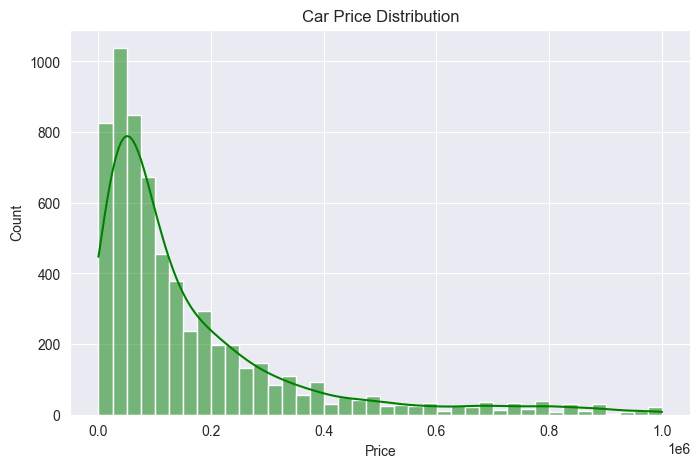

In [30]:
plt.figure(figsize=(8, 5))
sns.histplot(data['price'], kde=True, color='green', bins=40)
plt.title('Car Price Distribution')
plt.xlabel('Price')
plt.ylabel('Count')
plt.grid(True)
plt.show()

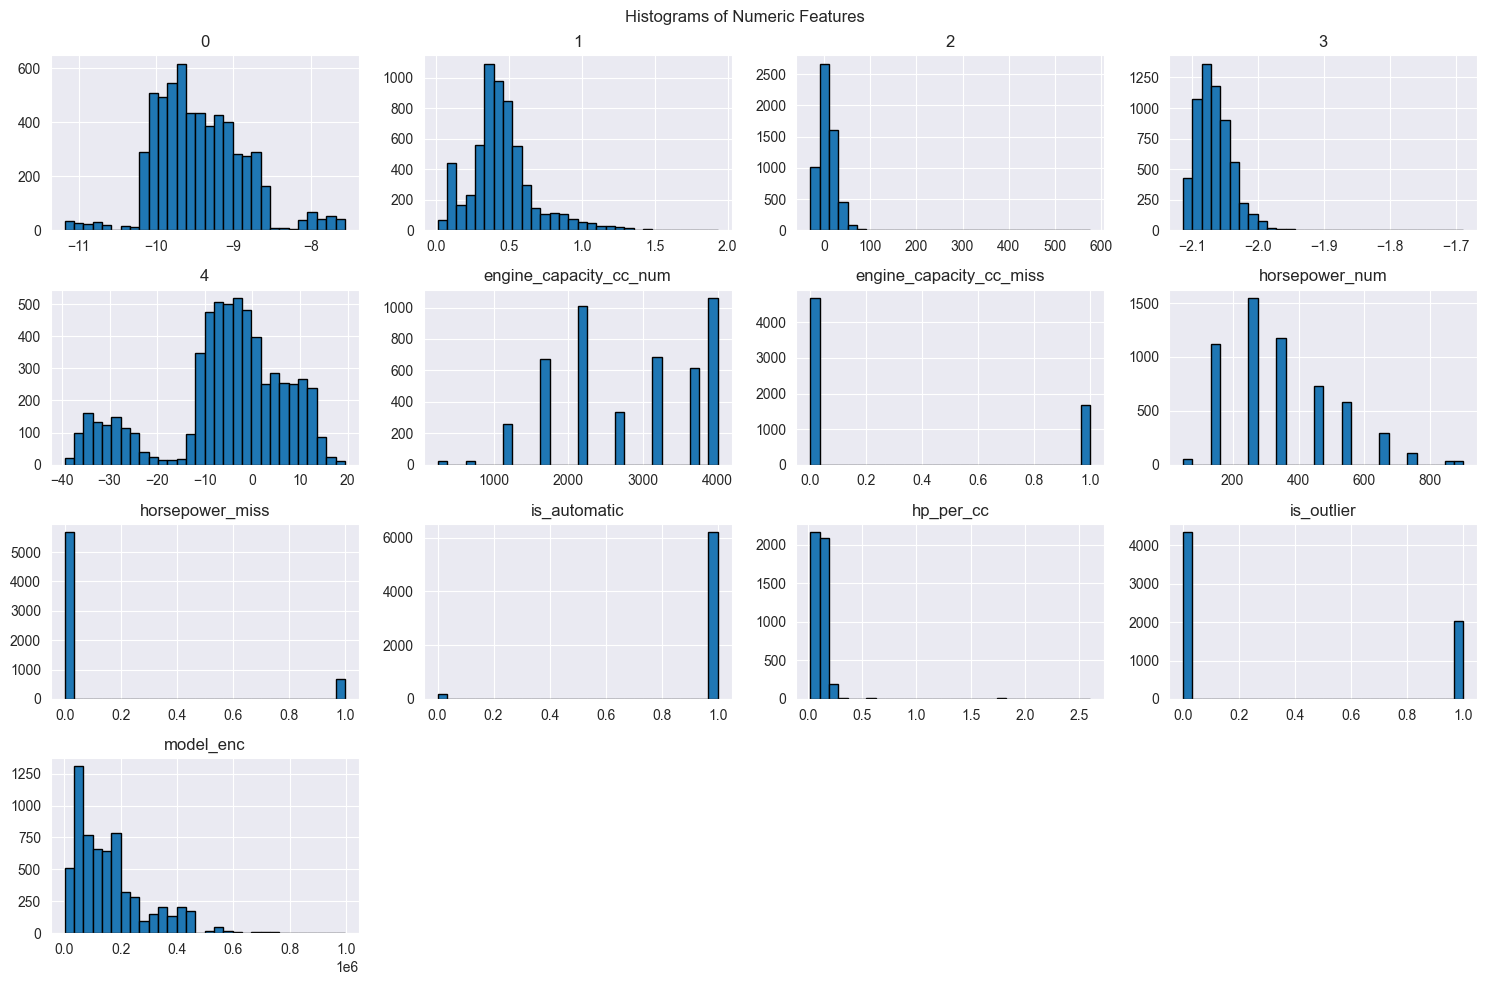

In [31]:
numeric_cols = data.select_dtypes(include='number').columns.drop('price', errors='ignore')

data[numeric_cols].hist(figsize=(15, 10), bins=30, edgecolor='black')
plt.suptitle('Histograms of Numeric Features')
plt.tight_layout()
plt.show()

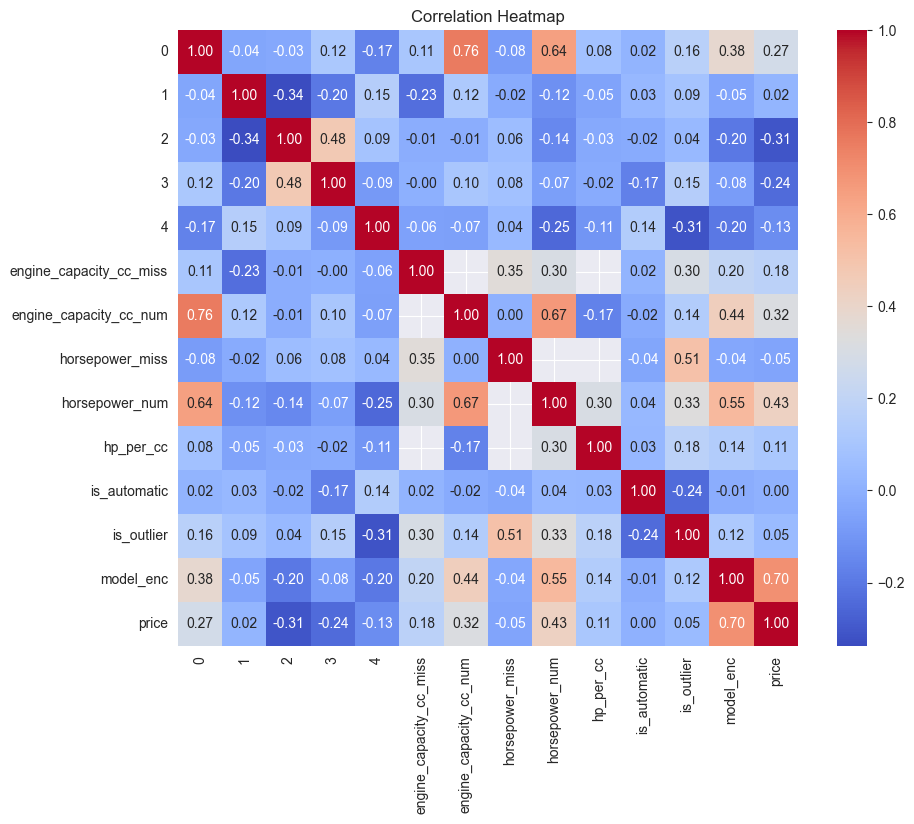

In [32]:
plt.figure(figsize=(10, 8))
correlation = data[numeric_cols.union(['price'])].corr()
sns.heatmap(correlation, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [33]:
print(correlation['price'].sort_values(ascending=False))

price                      1.000000
model_enc                  0.695101
horsepower_num             0.429517
engine_capacity_cc_num     0.318053
0                          0.273631
engine_capacity_cc_miss    0.175946
hp_per_cc                  0.107045
is_outlier                 0.046828
1                          0.019409
is_automatic               0.003505
horsepower_miss           -0.046558
4                         -0.131088
3                         -0.242796
2                         -0.311485
Name: price, dtype: float64


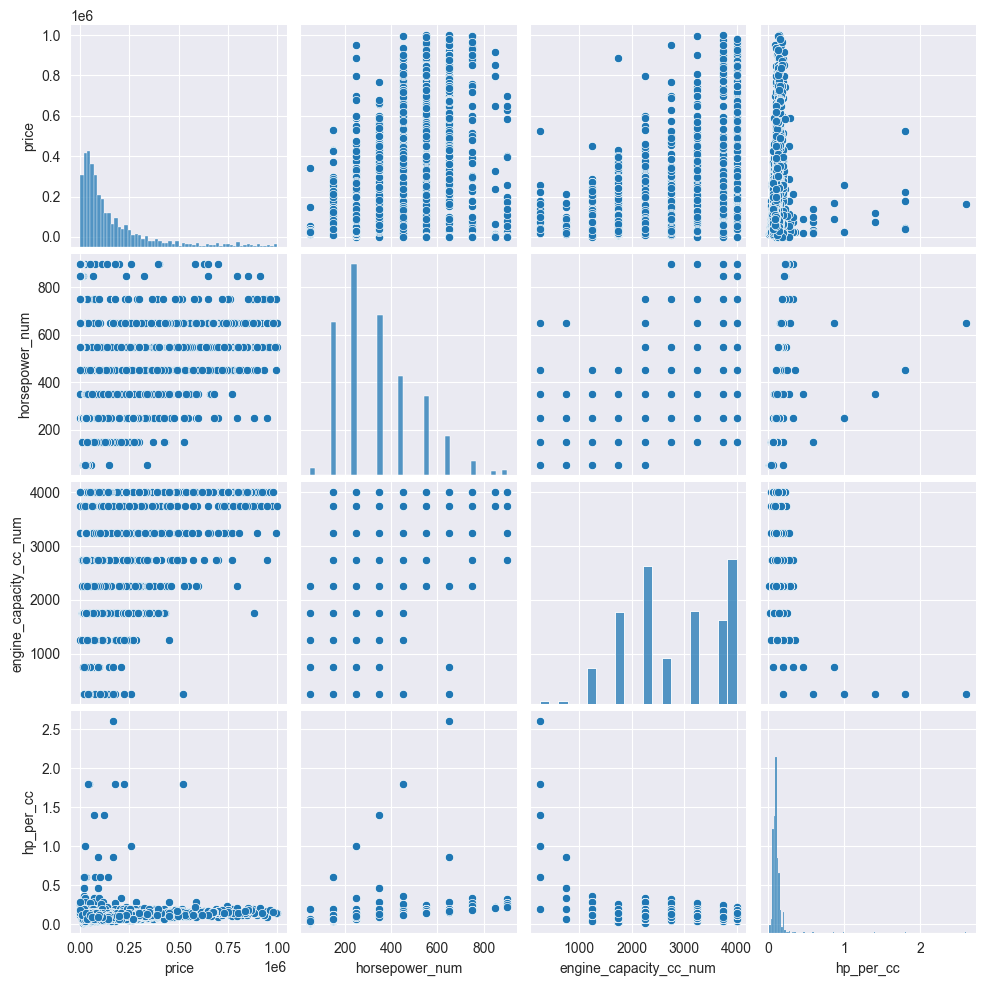

In [34]:
sns.pairplot(data, vars=['price', 'horsepower_num', 'engine_capacity_cc_num', 'hp_per_cc'])
plt.show()

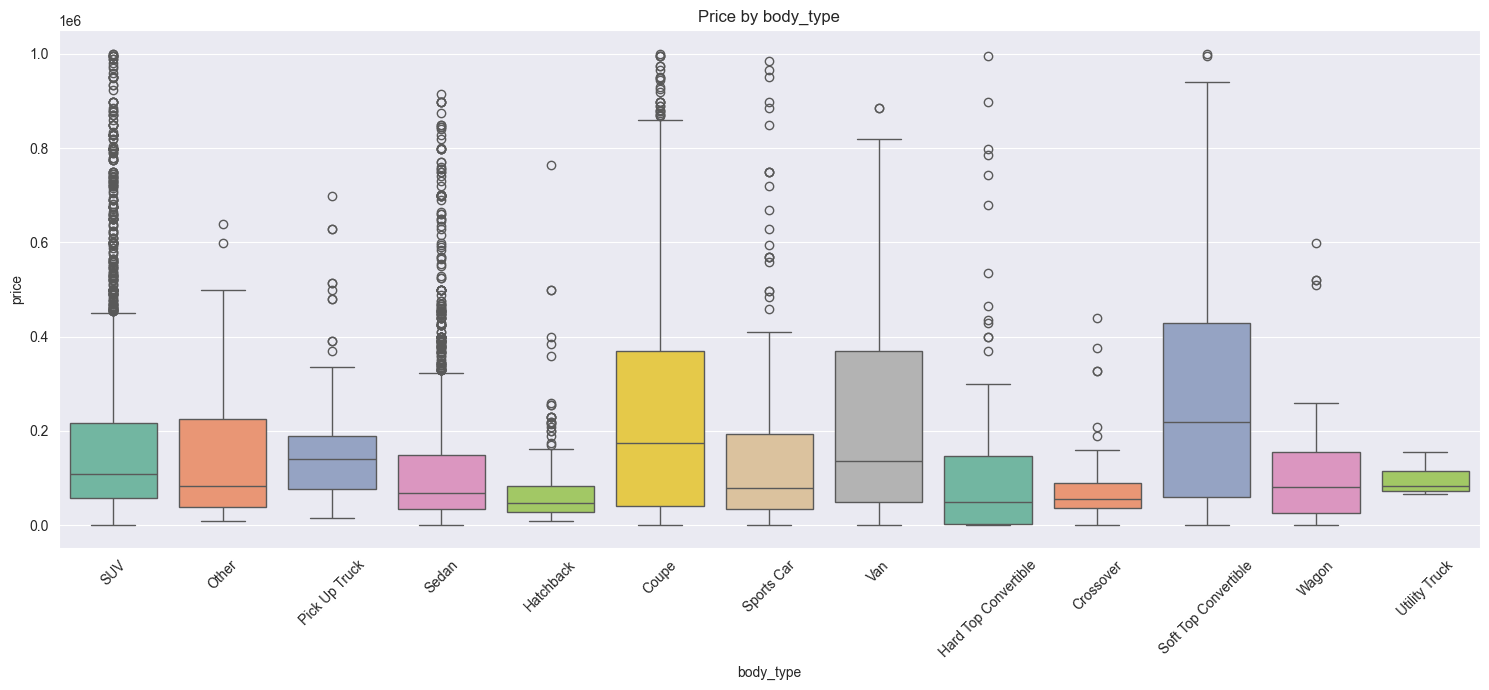

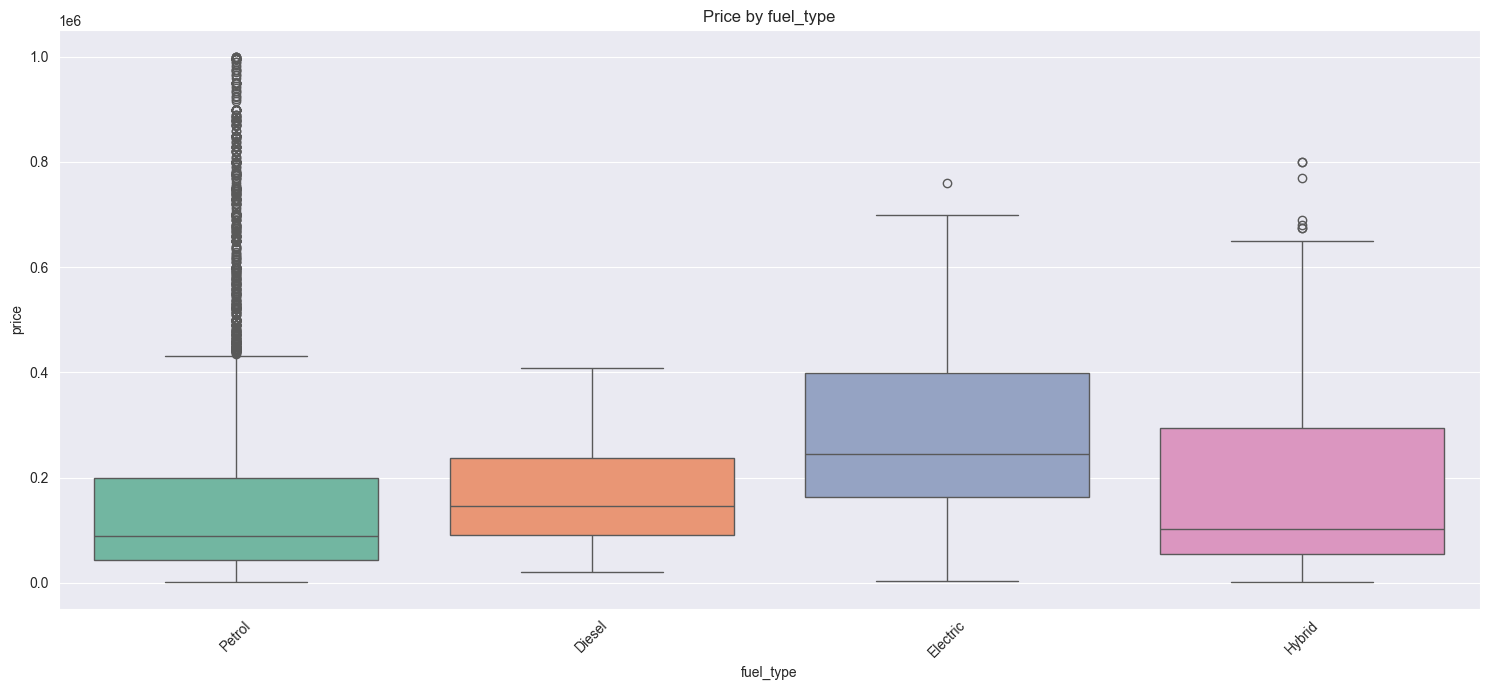

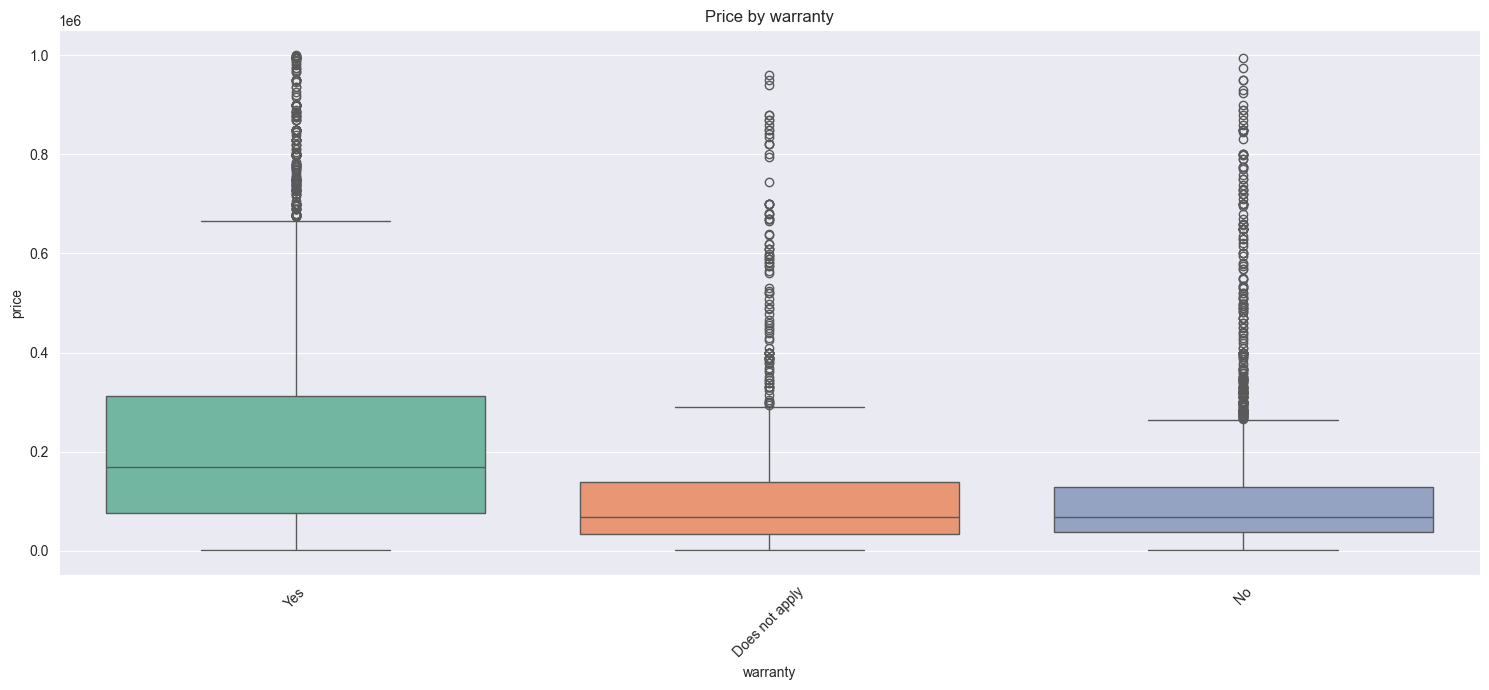

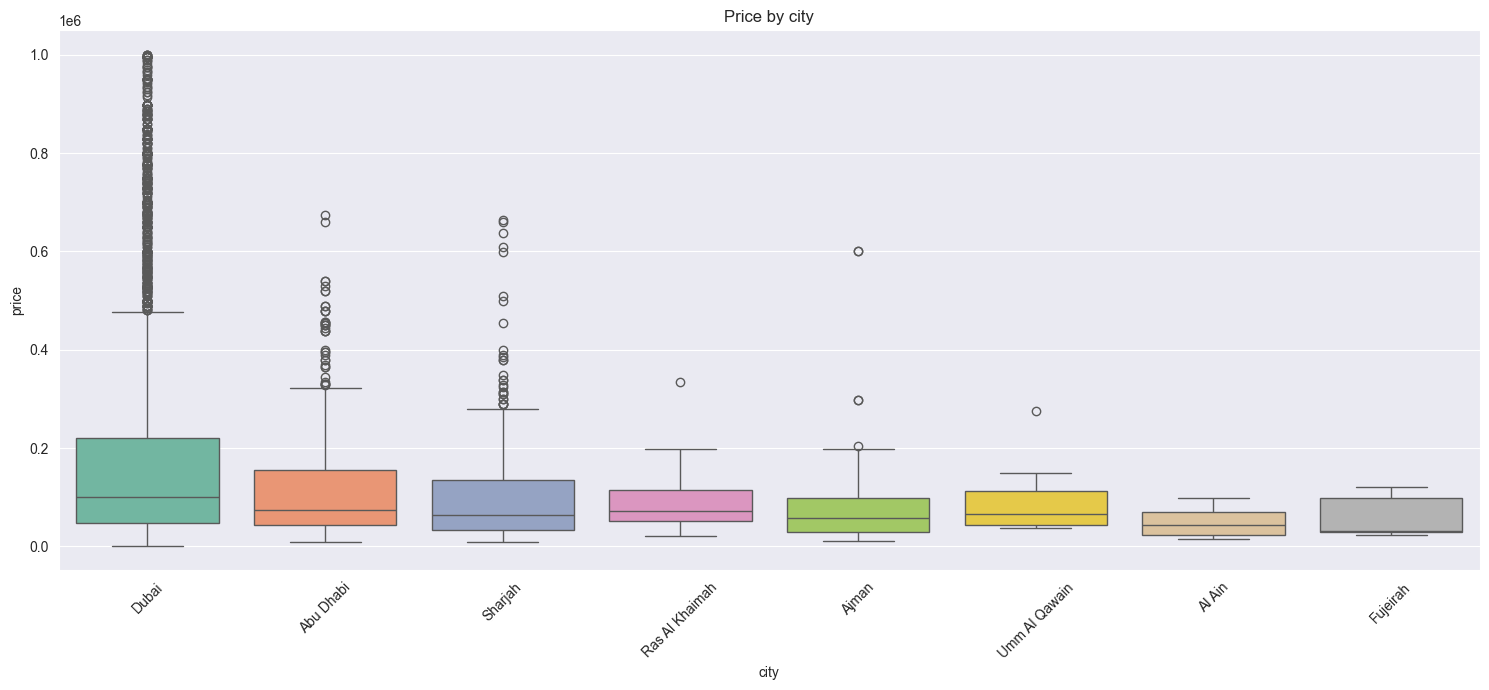

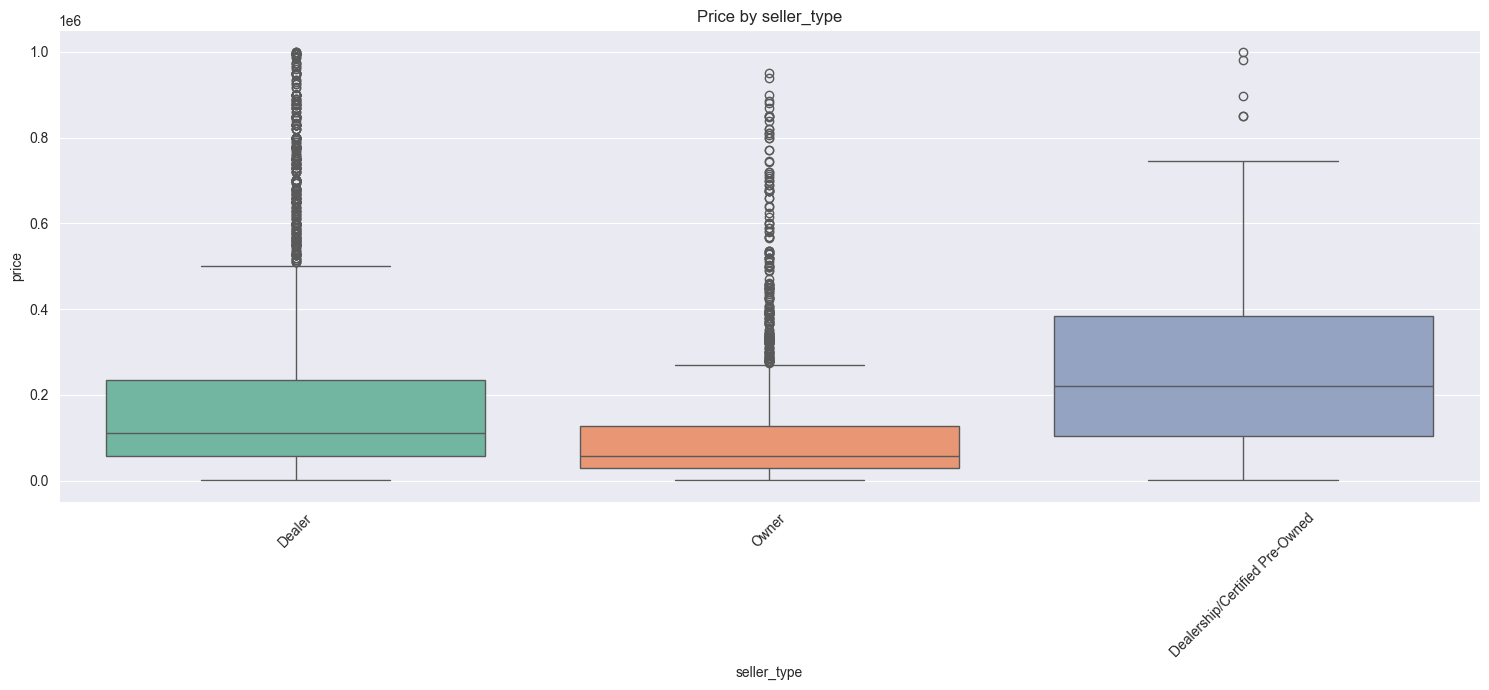

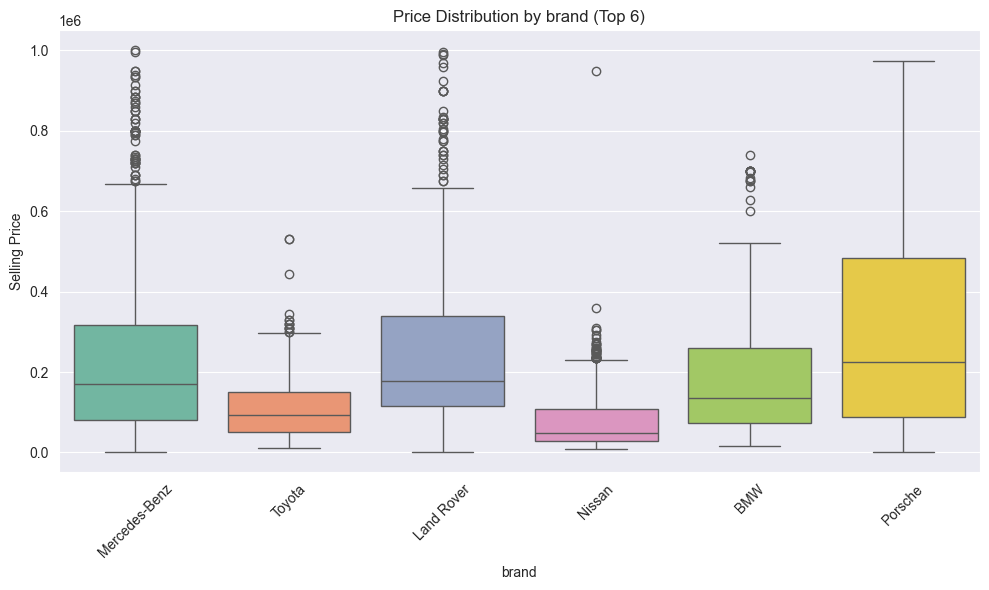

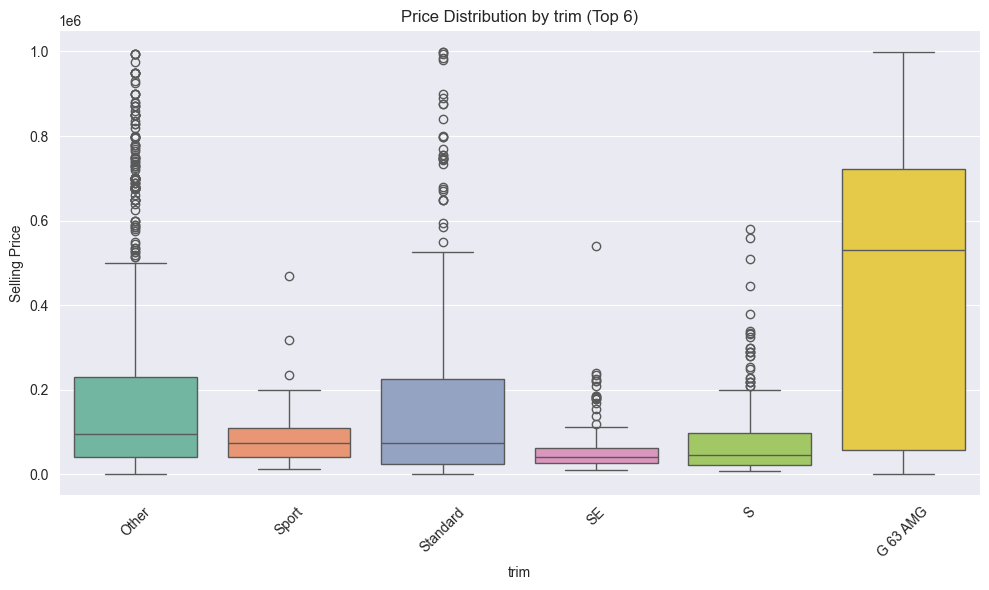

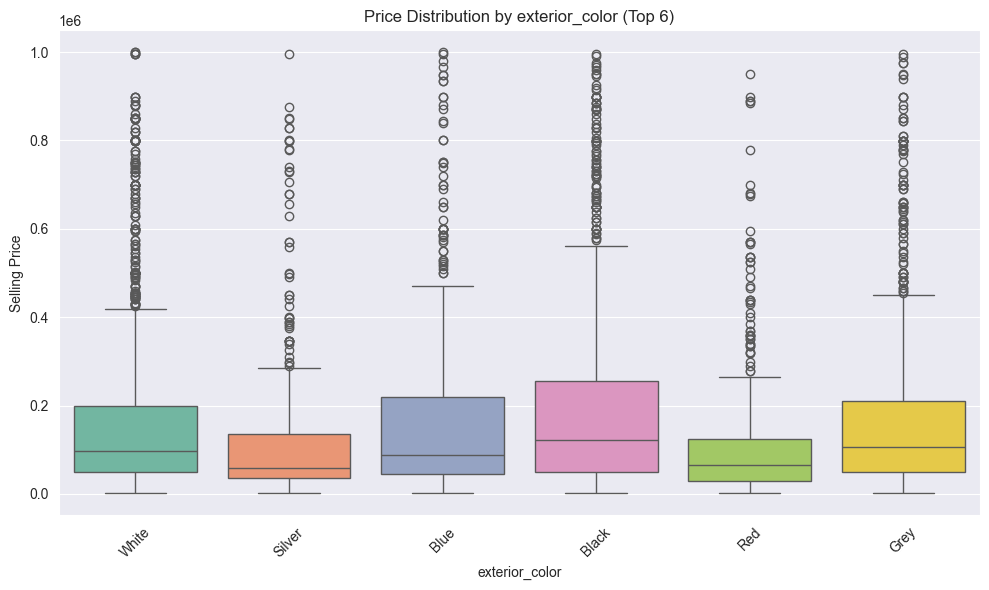

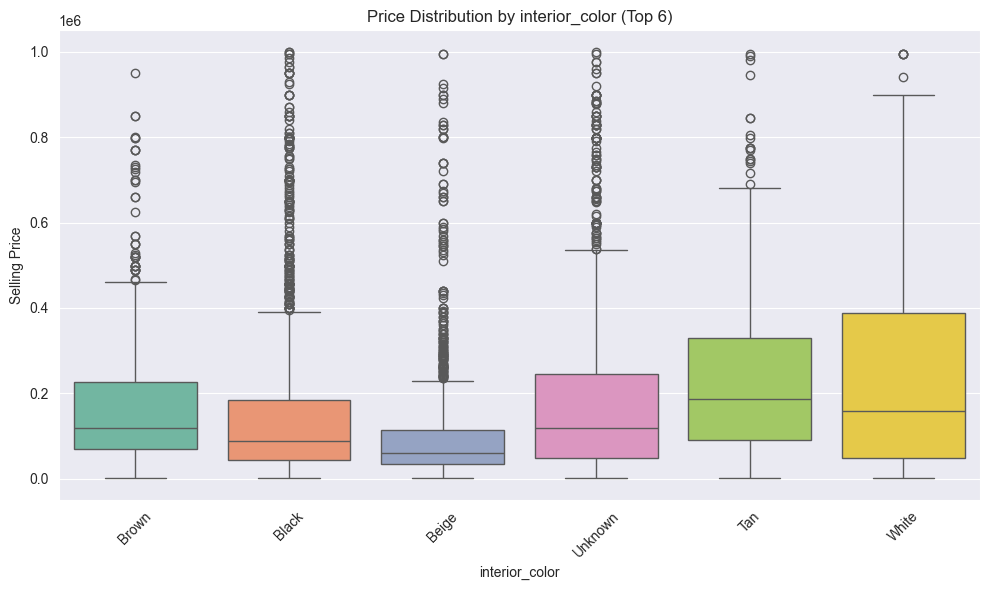

In [35]:
for col in [ 'body_type','fuel_type', 'warranty', 'city', 'seller_type']:
    plt.figure(figsize=(15, 7))
    n_colors = data[col].nunique()
    palette = sns.color_palette("Set2", n_colors=n_colors)
    sns.boxplot(x=col, y='price', hue=col, data=data, legend=False, palette=palette)
    plt.xticks(rotation=45)
    plt.title(f'Price by {col}')
    plt.tight_layout()
    plt.show()

for col in ['brand', 'trim', 'exterior_color', 'interior_color']:
    top = data[col].value_counts().nlargest(6).index
    plt.figure(figsize=(10, 6))
    palette = sns.color_palette("Set2", n_colors=6)
    sns.boxplot(
        data=data[data[col].isin(top)],
        x=col, y='price',
        hue=col,
        legend=False,
        palette=palette
    )
    plt.xticks(rotation=45)
    plt.title(f"Price Distribution by {col} (Top 6)")
    plt.ylabel("Selling Price")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

### Models Training

In [36]:
X_train = train_set.drop(columns=['price'])
y_train = train_set['price']
# y_train = np.log1p(y_train)


X_valid = valid_set.drop(columns=['price'])
y_valid = valid_set['price']

In [37]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

mean_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

mean_features = ['1', '2', '3', '4', 'engine_capacity_cc_num', 'engine_capacity_cc_miss', 'horsepower_num',
                 'horsepower_miss', 'is_automatic', 'hp_per_cc', 'is_outlier', 'model_enc']

median_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

median_features = ['0']

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num_mean', mean_transformer, mean_features),
        ('num_median', median_transformer, median_features),
        ('cat', categorical_transformer, categorical_features)
    ])

pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

X_train_transformed = pipeline.fit_transform(X_train)
X_valid_transformed = pipeline.transform(X_valid)


In [38]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

models = {
    "ExtraTrees": ExtraTreesRegressor(random_state=42),

    "SVR": SVR(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(verbosity=0, random_state=42),
    "CatBoost": CatBoostRegressor(verbose=0, random_state=42),

    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "DecisionTree": DecisionTreeRegressor(random_state=42),

    "GradientBoosting": GradientBoostingRegressor(),
    "AdaBoost": AdaBoostRegressor(),
    "KNeighbors": KNeighborsRegressor(),
    "MLP": MLPRegressor(max_iter=1000),
    "LightGBM": LGBMRegressor()
}


In [39]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np


def train_and_evaluate(models, X_train, y_train, X_valid, y_valid):
    results = {}

    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X_train, y_train)
        predictions = model.predict(X_valid)

        # predictions = np.expm1(predictions)

        mse = mean_squared_error(y_valid, predictions)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_valid, predictions)
        r2 = r2_score(y_valid, predictions)

        results[name] = {
            "MSE": mse,
            "RMSE": rmse,
            "MAE": mae,
            "R2": r2
        }
    return results


In [40]:
from sklearn.model_selection import cross_val_score

for name, model in models.items():
    if name in ['ExtraTrees', 'RandomForest','CatBoost']:
        cv_scores = cross_val_score(model, X_train_transformed, y_train, cv=5,
                                    scoring='neg_mean_squared_error')

        rmse_scores = np.sqrt(-cv_scores)
        print(f"Cross-validation scores {name} Model (RMSE):")
        print("Mean RMSE: {:.2f} (+/- {:.2f})".format(rmse_scores.mean(), rmse_scores.std() * 2))

Cross-validation scores ExtraTrees Model (RMSE):
Mean RMSE: 102573.12 (+/- 18692.55)
Cross-validation scores SVR Model (RMSE):
Mean RMSE: 201322.33 (+/- 15915.79)
Cross-validation scores RandomForest Model (RMSE):
Mean RMSE: 107887.99 (+/- 14563.16)
Cross-validation scores XGBoost Model (RMSE):
Mean RMSE: 109456.87 (+/- 13280.67)
Cross-validation scores CatBoost Model (RMSE):
Mean RMSE: 105288.79 (+/- 12109.58)
Cross-validation scores LinearRegression Model (RMSE):
Mean RMSE: 125669.59 (+/- 10400.16)
Cross-validation scores Ridge Model (RMSE):
Mean RMSE: 124241.97 (+/- 8663.85)


C:\Users\GED\PycharmProjects\Hands_on_ML\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.119e+12, tolerance: 1.817e+10
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\GED\PycharmProjects\Hands_on_ML\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.275e+12, tolerance: 1.753e+10
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\GED\PycharmProjects\Hands_on_ML\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the 

Cross-validation scores Lasso Model (RMSE):
Mean RMSE: 125523.88 (+/- 10460.50)
Cross-validation scores ElasticNet Model (RMSE):
Mean RMSE: 133967.49 (+/- 9805.58)
Cross-validation scores DecisionTree Model (RMSE):
Mean RMSE: 150513.15 (+/- 8205.97)
Cross-validation scores GradientBoosting Model (RMSE):
Mean RMSE: 116866.39 (+/- 9560.57)
Cross-validation scores AdaBoost Model (RMSE):
Mean RMSE: 136774.20 (+/- 8823.77)
Cross-validation scores KNeighbors Model (RMSE):
Mean RMSE: 120303.60 (+/- 14684.07)


C:\Users\GED\PycharmProjects\Hands_on_ML\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\GED\PycharmProjects\Hands_on_ML\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\GED\PycharmProjects\Hands_on_ML\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\GED\PycharmProjects\Hands_on_ML\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged ye

Cross-validation scores MLP Model (RMSE):
Mean RMSE: 136677.51 (+/- 8988.93)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1864
[LightGBM] [Info] Number of data points in the train set: 5095, number of used features: 139
[LightGBM] [Info] Start training from score 164336.188027
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1862
[LightGBM] [Info] Number of data points in the train set: 5095, number of used features: 137
[LightGBM] [Info] Start training from score 161211.579195
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1867
[LightGBM] [Info] Number of data 

C:\Users\GED\PycharmProjects\Hands_on_ML\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\GED\PycharmProjects\Hands_on_ML\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\GED\PycharmProjects\Hands_on_ML\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [41]:
results = train_and_evaluate(models, X_train_transformed, y_train, X_valid_transformed, y_valid)
results_df = pd.DataFrame(results).T.sort_values(by="RMSE")
print(results_df)

# random_state=1 :
#                      MSE           RMSE          MAE        R2
# ExtraTrees  8.854210e+09  94096.810707  44839.4072  0.726003
#
#
# random_state=42 :
#                      MSE           RMSE          MAE        R2
# ExtraTrees  1.245245e+10  111590.540246  49160.675819  0.644782

Training ExtraTrees...
Training SVR...
Training RandomForest...
Training XGBoost...
Training CatBoost...
Training LinearRegression...
Training Ridge...
Training Lasso...


C:\Users\GED\PycharmProjects\Hands_on_ML\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.915e+12, tolerance: 2.267e+10
  model = cd_fast.sparse_enet_coordinate_descent(


Training ElasticNet...
Training DecisionTree...
Training GradientBoosting...
Training AdaBoost...
Training KNeighbors...
Training MLP...
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1887
[LightGBM] [Info] Number of data points in the train set: 6369, number of used features: 149
[LightGBM] [Info] Start training from score 163310.384048
                           MSE           RMSE            MAE        R2
ExtraTrees        1.245245e+10  111590.540246   49160.675819  0.644782
CatBoost          1.407062e+10  118619.638341   57013.592715  0.598622
RandomForest      1.472810e+10  121359.366321   55831.857238  0.579867
LightGBM          1.495653e+10  122296.894019   59383.379844  0.573351
GradientBoosting  1.529703e+10  123681.166457   64424.088732  0.563638
KNeighbors        1.694824e+10  130185.417004   63694.412680  0.51653

C:\Users\GED\PycharmProjects\Hands_on_ML\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\GED\PycharmProjects\Hands_on_ML\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [42]:
for name, model in models.items():
    if name in ['ExtraTrees', 'RandomForest','CatBoost']:
        importances = model.feature_importances_
        features = X_train.columns
        print(f"\nFeature Importances for model: {name}")
        for feat, imp in sorted(zip(features, importances), key=lambda x: x[1], reverse=True):
            print(f"{feat:<30} {imp:.10f}")



Feature Importances for model: ExtraTrees
warranty                       0.3840509939
trim                           0.0816575616
2                              0.0472050964
1                              0.0402133108
city                           0.0118712201
3                              0.0103573815
exterior_color                 0.0102645739
0                              0.0101484158
4                              0.0089756033
brand                          0.0071316211
interior_color                 0.0068327268
horsepower_num                 0.0036146233
is_outlier                     0.0026289760
body_type                      0.0020496072
fuel_type                      0.0012167385
horsepower_miss                0.0010315788
hp_per_cc                      0.0005533673
engine_capacity_cc_miss        0.0000690906
model_enc                      0.0000155934
is_automatic                   0.0000044920
seller_type                    0.0000029221
engine_capacity_cc_num         0.

In [43]:
models = {
    "ExtraTrees": ExtraTreesRegressor(random_state=42),
    "RandomForest": RandomForestRegressor(random_state=42),
    "CatBoost": CatBoostRegressor(verbose=0, random_state=42)
}

param_grids = {
    "ExtraTrees": {
        # 'pca__n_components': [5, 10, 15, 20, 22],
        'model__n_estimators': [100, 300, 500, 800],
        'model__max_depth': [None, 10, 20, 30, 50],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
        'model__max_features': ['sqrt', 'log2', None]
    },
    "RandomForest": {
        # 'pca__n_components': [5, 10, 15, 20, 22],
        'model__n_estimators': [100, 300, 500, 800],
        'model__max_depth': [None, 10, 20, 30, 50],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
        'model__max_features': ['sqrt', 'log2', None]
    },
    "CatBoost": {
        # 'pca__n_components': [5, 10, 15, 20, 22],
        'model__iterations': [500, 1000],
        'model__depth': [4, 6, 8, 10],
        'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'model__l2_leaf_reg': [1, 3, 5, 7, 9],
        'model__bagging_temperature': [0, 0.5, 1]
    }
}



In [ ]:
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, GridSearchCV

preds = {}

pplines = {}
for name, model in models.items():
    print(f"\n GridSearch for {name}...")

    pipeline = Pipeline([
        # ('pca', PCA()),
        ('model', model)
    ])

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grids[name],
        cv=5,
        scoring='neg_mean_squared_error',
        verbose=2,
        n_jobs=-1
    )

    grid_search.fit(X_train_transformed, y_train)

    print(f" Best params for {name}:")
    print(grid_search.best_params_)
    print(f" Best CV score (neg MSE): {-grid_search.best_score_:.4f}")

    best_pipeline = grid_search.best_estimator_

    y_pred = best_pipeline.predict(X_valid_transformed)

    rmse = mean_squared_error(y_valid, y_pred)
    r2 = r2_score(y_valid, y_pred)

    preds[name] = y_pred
    pplines[name] = best_pipeline

In [ ]:
for name, ppl in pplines.items():
    cv_scores = cross_val_score(
        ppl,
        X_train_transformed,
        y_train,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    print(f"Final {name}_model 5-fold CV RMSE: {(-cv_scores.mean()) ** 0.5:.4f} ± {cv_scores.std() ** 0.5:.4f}")


In [ ]:
for name, y_pred in preds.items():
    rmse = mean_squared_error(y_valid, y_pred)
    rmse = np.sqrt(rmse)
    mae = mean_absolute_error(y_valid, y_pred)
    r2 = r2_score(y_valid, y_pred)

    print(f"{name} on Validation:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²:   {r2:.4f}")
    print()
